In [1]:
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
lb = LabelBinarizer()

import matplotlib.pyplot as plt
import random
import os
import numpy as np
np.set_printoptions(threshold=10000)
import cv2
import pickle

# 遍历所有文件名
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            yield f

# 数据切分
def split_train(data,label,test_ratio):
    np.random.seed(43)
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data[train_indices],data[test_indices],label[train_indices],label[test_indices]

image_dir = ("./train/cats/", "./train/dogs/", "./train/panda/")
image_path = []
data = []
labels = []

# 1、数据预处理
# 读取图像路径
for path in image_dir:
    for i in findAllFile(path):
        image_path.append(path+i)

# 随机化数据
random.seed(43)
random.shuffle(image_path)

# 读取图像数据，读取label文件名数据
for j in image_path:
    image = cv2.imread(j)
    image = cv2.resize(image,(64,64))
    # image = cv2.resize(image,(32,32)).flatten() # 将图片resize到64，且去掉拉长操作
    data.append(image)
    label = j.split("/")[-2]
    labels.append(label)

# 规格化数据
data = np.array(data,dtype="float") / 255.0
labels = np.array(labels)
# 数据切分
(trainX,testX,trainY,testY) = split_train(data,labels,test_ratio=0.25)
# 将cat、dog、panda规格化数据
trainY = lb.fit_transform(trainY)
testY = lb.fit_transform(testY)

# 最终数据结果
print(trainX)
print(data)
print(data.shape) # (3000, 3072)，32x32x3=3072，其图片3通道被拉长成一条操作
print(lb.classes_) # ['cats' 'dogs' 'panda']

[[[[0.14509804 0.16470588 0.20392157]
   [0.1254902  0.18431373 0.25098039]
   [0.02745098 0.09019608 0.06666667]
   ...
   [0.32941176 0.40392157 0.51764706]
   [0.48627451 0.59607843 0.64313725]
   [0.48235294 0.59215686 0.64705882]]

  [[0.12156863 0.13333333 0.18431373]
   [0.19607843 0.31372549 0.38823529]
   [0.05882353 0.07843137 0.05882353]
   ...
   [0.35686275 0.43921569 0.54901961]
   [0.50588235 0.58431373 0.61176471]
   [0.48235294 0.55686275 0.61176471]]

  [[0.29019608 0.3254902  0.43529412]
   [0.2        0.28627451 0.39215686]
   [0.4627451  0.52941176 0.7254902 ]
   ...
   [0.31372549 0.40392157 0.50196078]
   [0.51372549 0.6        0.61176471]
   [0.03137255 0.12156863 0.10980392]]

  ...

  [[0.72941176 0.82352941 0.94901961]
   [0.78039216 0.8745098  0.97254902]
   [0.76470588 0.85098039 0.98039216]
   ...
   [0.45098039 0.49019608 0.57647059]
   [0.42352941 0.45882353 0.48235294]
   [0.4627451  0.4627451  0.47058824]]

  [[0.75686275 0.85098039 0.95686275]
   [0.7

In [2]:
from keras.models import Sequential
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.initializers import TruncatedNormal
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense


model = Sequential()
chanDim = 1
inputShape = (64, 64, 3)

model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL 
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# (CONV => RELU) * 3 => POOL 
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

# FC层
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
#model.add(Dropout(0.6))

# softmax 分类,kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.01)
model.add(Dense(len(lb.classes_)))
model.add(Activation("softmax"))

# 损失函数和优化器，正则惩罚
EPOCHS = 200
model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001),metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY),epochs=EPOCHS, batch_size=32)

Epoch 1/200


G:\ai\lib\site-packages\keras\optimizers\legacy\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


71/71 [==============================] - 29s 400ms/step - loss: 0.9931 - accuracy: 0.5452 - val_loss: 1.2028 - val_accuracy: 0.3476
Epoch 2/200
71/71 [==============================] - 24s 334ms/step - loss: 0.7483 - accuracy: 0.6462 - val_loss: 1.1932 - val_accuracy: 0.3422
Epoch 3/200
71/71 [==============================] - 24s 337ms/step - loss: 0.6505 - accuracy: 0.7000 - val_loss: 1.4177 - val_accuracy: 0.3422
Epoch 4/200
71/71 [==============================] - 23s 326ms/step - loss: 0.5930 - accuracy: 0.7241 - val_loss: 1.3362 - val_accuracy: 0.4452
Epoch 5/200
71/71 [==============================] - 23s 330ms/step - loss: 0.5404 - accuracy: 0.7588 - val_loss: 1.1143 - val_accuracy: 0.5307
Epoch 6/200
71/71 [==============================] - 23s 328ms/step - loss: 0.4687 - accuracy: 0.8020 - val_loss: 0.9191 - val_accuracy: 0.5695
Epoch 7/200
71/71 [==============================] - 23s 329ms/step - loss: 0.4115 - accuracy: 0.8318 - val_loss: 1.4468 - val_accuracy: 0.4733
Epoc

71/71 [==============================] - 25s 353ms/step - loss: 0.0177 - accuracy: 0.9996 - val_loss: 1.5910 - val_accuracy: 0.5521
Epoch 58/200
71/71 [==============================] - 25s 354ms/step - loss: 0.0245 - accuracy: 0.9996 - val_loss: 0.7474 - val_accuracy: 0.7273
Epoch 59/200
71/71 [==============================] - 25s 358ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 0.7460 - val_accuracy: 0.7112
Epoch 60/200
71/71 [==============================] - 25s 355ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.7472 - val_accuracy: 0.7152
Epoch 61/200
71/71 [==============================] - 26s 364ms/step - loss: 0.0171 - accuracy: 0.9987 - val_loss: 1.5120 - val_accuracy: 0.5749
Epoch 62/200
71/71 [==============================] - 26s 361ms/step - loss: 0.0491 - accuracy: 0.9938 - val_loss: 0.7454 - val_accuracy: 0.7206
Epoch 63/200
71/71 [==============================] - 25s 355ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 1.1952 - val_accuracy: 0.629

71/71 [==============================] - 26s 370ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.7830 - val_accuracy: 0.7246
Epoch 114/200
71/71 [==============================] - 26s 366ms/step - loss: 0.0069 - accuracy: 0.9996 - val_loss: 1.1622 - val_accuracy: 0.6283
Epoch 115/200
71/71 [==============================] - 26s 360ms/step - loss: 0.0520 - accuracy: 0.9889 - val_loss: 0.8149 - val_accuracy: 0.7059
Epoch 116/200
71/71 [==============================] - 26s 364ms/step - loss: 0.0124 - accuracy: 0.9996 - val_loss: 0.7948 - val_accuracy: 0.7259
Epoch 117/200
71/71 [==============================] - 26s 363ms/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.7905 - val_accuracy: 0.7193
Epoch 118/200
71/71 [==============================] - 26s 364ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 0.7869 - val_accuracy: 0.7139
Epoch 119/200
71/71 [==============================] - 26s 363ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.7819 - val_accuracy:

71/71 [==============================] - 25s 358ms/step - loss: 0.0066 - accuracy: 0.9996 - val_loss: 0.8883 - val_accuracy: 0.7126
Epoch 170/200
71/71 [==============================] - 25s 358ms/step - loss: 0.0132 - accuracy: 0.9982 - val_loss: 0.8009 - val_accuracy: 0.7366
Epoch 171/200
71/71 [==============================] - 26s 368ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.7811 - val_accuracy: 0.7353
Epoch 172/200
71/71 [==============================] - 26s 363ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.7893 - val_accuracy: 0.7326
Epoch 173/200
71/71 [==============================] - 26s 368ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.7870 - val_accuracy: 0.7299
Epoch 174/200
71/71 [==============================] - 26s 370ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.7965 - val_accuracy: 0.7353
Epoch 175/200
71/71 [==============================] - 26s 364ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7919 - val_accuracy:

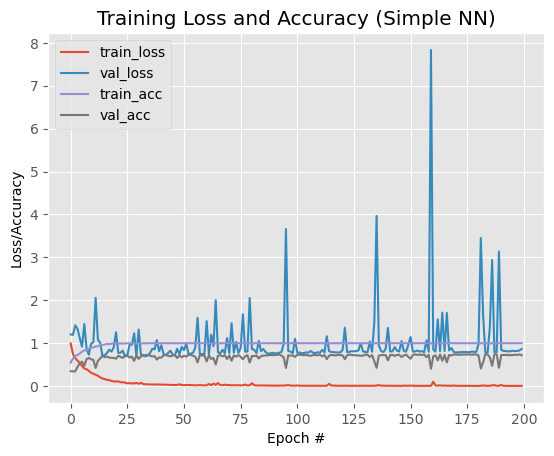

In [3]:
# 4、数据可视化
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig("./plot.png")

In [4]:
# 5、保存模型到本地
model.save("./model")
f = open("./label.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

INFO:tensorflow:Assets written to: ./model\assets


INFO:tensorflow:Assets written to: ./model\assets


In [18]:
# 6、测试模型
test_image_dir =  "./test/"
test_image_path = []
for i in findAllFile(test_image_dir):
    test_image_path.append(test_image_dir+i)
test_image = random.sample(test_image_path, 1)[0]

# 数据预处理
image = cv2.imread(test_image)
output = image.copy()
image = image.astype("float") / 255.0
# image = cv2.resize(image,(32,32)).flatten() #不拉平，且改为64x64
# image = image.reshape((1, image.shape[0])) #数据改为数组
image = cv2.resize(image,(64,64))
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# 加载模型
model = load_model("./model")
lb = pickle.loads(open("./label.pickle", "rb").read())
# 开始预测
preds = model.predict(image)

# 查看预测结果
text1 = "{}: {:.2f}% ".format(lb.classes_[0], preds[0][0] * 100)
text2 = "{}: {:.2f}% ".format(lb.classes_[1], preds[0][1] * 100)
text3 = "{}: {:.2f}% ".format(lb.classes_[2], preds[0][2] * 100)
cv2.putText(output, text1, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0, 0, 255), 2)
cv2.putText(output, text2, (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0, 0, 255), 2)
cv2.putText(output, text3, (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0, 0, 255), 2)
cv2.imshow("Image", output)
cv2.waitKey(0)

1/1 [==============================] - 0s 147ms/step


-1